In [1]:
import networkx as nx
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

import sys
sys.path.append('../src')
from utils.graph_utils import load_edges, get_video_graph, get_user_graph, load_sentiment, get_sentiment_video_graph, get_sentiment_user_graph
from fsm_viz import graph_to_tikz

from random import seed
seed(1)

In [2]:
edges = load_edges('../data/hashtags/edges/biden2024_edges.txt')
edges = edges[edges.stitchee_user != '@meidastouch']
nogolist = ['@thebluntprogressive', '@6twistedgirl66', '@mr_rational_debater', '@newsweek', '@mrwilliams550', '@theoldermillennial.1']
edges = edges[~edges.stitcher_user.isin(nogolist)]

sentiment = load_sentiment('../data/hashtags/transcriptions/biden2024_transcription_data.jsonl')

In [3]:
sentiment

,video_id,username,scene,language,is_english,audio_type,is_speech,stitchee_id,stitchee_username,transcription,timestamped_classifications,sentiment,sentiment_scores,pos,neg,neu,compound
0,7369050688912952622,anti_maga_anti_leftist,1,en,True,Speech,True,7369046404402072874,alexiswilson40,"He believes in his own power, his own right to...","[{'timestamp': 0, 'category_name': 'Speech', '...",neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000
1,7369050688912952622,anti_maga_anti_leftist,2,en,True,Speech,True,-1,None,Hell we couldn't throughout her life has been ...,"[{'timestamp': 0, 'category_name': 'Speech', '...",positive,"{'neg': 0.053, 'neu': 0.868, 'pos': 0.078, 'co...",0.078,0.053,0.868,0.5310
2,7369303721081146667,anti_maga_anti_leftist,1,en,True,Speech,True,7323253962843393323,sarahlynne090,You want to know what that sound like? A dicta...,"[{'timestamp': 0, 'category_name': 'Speech', '...",positive,"{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'comp...",0.338,0.000,0.662,0.4753
3,7369303721081146667,anti_maga_anti_leftist,2,en,True,Speech,True,-1,None,And you wonder why Trump says he loves the poo...,"[{'timestamp': 0, 'category_name': 'Speech', '...",negative,"{'neg': 0.119, 'neu': 0.812, 'pos': 0.069, 'co...",0.069,0.119,0.812,-0.6454
4,7370344417837813038,anti_maga_anti_leftist,1,en,True,Speech,True,7370338195956944170,drewcifers,bad built bush body that would not be engaging...,"[{'timestamp': 0, 'category_name': 'Speech', '...",negative,"{'neg': 0.381, 'neu': 0.619, 'pos': 0.0, 'comp...",0.000,0.381,0.619,-0.6742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,7374952599919037742,r.l.humbird,2,en,True,Silence,False,-1,None,"Yeah, that's it. Guilty on all counts. So prob...","[{'timestamp': 0, 'category_name': 'Speech', '...",positive,"{'neg': 0.129, 'neu': 0.599, 'pos': 0.272, 'co...",0.272,0.129,0.599,0.4767
270,7373370736397864235,ricktheoneandonly,2,en,True,Music,False,-1,None,Thank you.,"[{'timestamp': 0, 'category_name': 'Silence', ...",positive,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.714,0.000,0.286,0.3612
271,7375214725476519210,thebluntprogressive,1,en,True,Music,False,7374950724221848863,shaunab10,The red wire blue fine will be up high And we ...,"[{'timestamp': 0, 'category_name': 'Music', 's...",positive,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",0.087,0.000,0.913,0.2023
272,7375214725476519210,thebluntprogressive,2,en,True,Music,False,-1,None,And we don't give a damn if you don't like thi...,"[{'timestamp': 0, 'category_name': 'Music', 's...",positive,"{'neg': 0.078, 'neu': 0.663, 'pos': 0.26, 'com...",0.260,0.078,0.663,0.6057


In [4]:
ug = get_sentiment_user_graph(edges, sentiment)
lcc_users = ug.components(mode='weak').giant().vs['name']
edges_filtered = edges[(edges.stitcher_user.isin(lcc_users)) | (edges.stitchee_user.isin(lcc_users))]
#user_counts = pd.concat((edges_filtered.stitcher_user, edges_filtered.stitchee_user)).value_counts()
#frequent_users = user_counts[user_counts > 1].index
#edges_filtered = edges_filtered[(edges_filtered.stitcher_user.isin(frequent_users)) | (edges_filtered.stitchee_user.isin(frequent_users))]

In [5]:
alphabet_map = {user: chr(65 + i) for i, user in enumerate(lcc_users)}
vid_dict = pd.concat((edges_filtered[['stitchee', 'stitchee_user']], edges_filtered[['stitcher', 'stitcher_user']].rename(columns={'stitcher': 'stitchee', 'stitcher_user': 'stitchee_user'}))).set_index('stitchee').stitchee_user.to_dict()

In [6]:
vg = get_sentiment_video_graph(edges_filtered, sentiment)
vg.vs['user'] = [vid_dict[vid] for vid in vg.vs['name']]
ug = get_sentiment_user_graph(edges_filtered, sentiment)
ug.vs['user'] = ug.vs['name']

In [7]:
sentiment_map = {0: 'SentimentNeutral', 1: 'SentimentPositive', 2: 'SentimentNegative'}

In [8]:
g = vg
# layout = g.layout_graphopt(niter=2000, node_charge=0.01)
# layout = g.layout_fruchterman_reingold()
layout = g.layout_kamada_kawai()

max_coord = max([abs(x) for coor in layout for x in coor])
scaling = 3.25

tikz_code = '\\begin{tikzpicture}\n'
for i, (x, y) in enumerate(layout):
    label = alphabet_map[g.vs[i]['user']]
    sentiment = sentiment_map.get(g.vs[i]['sentiment_value'], 'SentimentMissing')
    x = x * scaling / max_coord
    y = y * scaling / max_coord
    tikz_code += f'\t\\Vertex[x={x:.2f}, y={y:.2f}, label=${label}$, color={sentiment}]{{{i}}}\n'

for i, j in g.get_edgelist():
    tikz_code += f'\t\\Edge[Direct]({i})({j})\n'
tikz_code += '\\end{tikzpicture}'

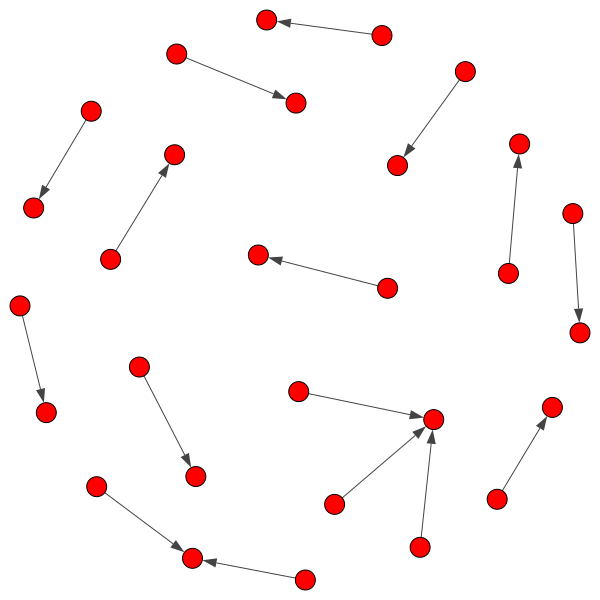

In [9]:
ig.plot(g, layout=layout)

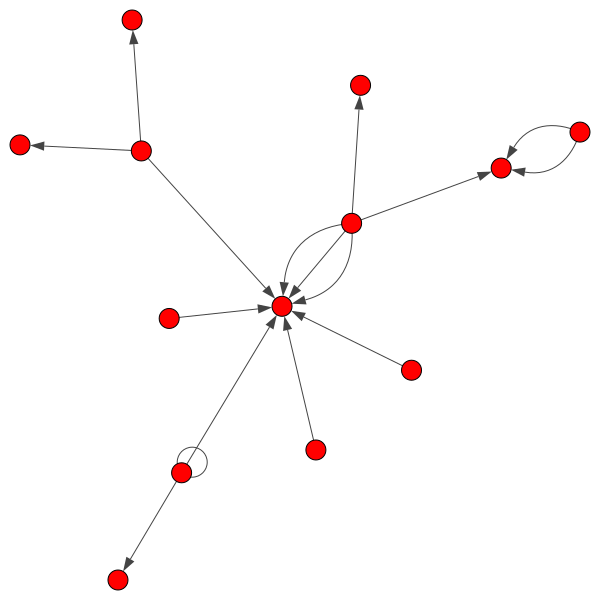

In [10]:
seed(14)
g = ug
layout = g.layout_graphopt(niter=2000, node_charge=0.01)

max_coord = max([x for coor in layout for x in coor])
scaling = 3

tikz_code = '\\begin{tikzpicture}\n'
for i, (x, y) in enumerate(layout):
    label = alphabet_map[g.vs[i]['user']]
    x = x * scaling / max_coord
    y = y * scaling / max_coord
    tikz_code += f'\t\\Vertex[x={x:.2f}, y={y:.2f}, label=${label}$]{{{i}}}\n'

for e in g.es:
    i, j = e.tuple
    sentiment = sentiment_map.get(e['stitcher_sentiment_value'], 'SentimentMissing')    
    tikz_code += f'\t\\Edge[Direct, color={sentiment}]({i})({j})\n'
tikz_code += '\\end{tikzpicture}'
ig.plot(g, layout=layout)

In [11]:
print(tikz_code)

\begin{tikzpicture}
	\Vertex[x=-0.92, y=1.88, label=$A$]{0}
	\Vertex[x=-1.54, y=2.82, label=$B$]{1}
	\Vertex[x=3.00, y=-1.13, label=$C$]{2}
	\Vertex[x=2.23, y=-0.81, label=$D$]{3}
	\Vertex[x=0.40, y=1.67, label=$E$]{4}
	\Vertex[x=0.07, y=0.41, label=$F$]{5}
	\Vertex[x=-1.04, y=0.51, label=$G$]{6}
	\Vertex[x=1.34, y=0.97, label=$H$]{7}
	\Vertex[x=-1.31, y=-0.97, label=$I$]{8}
	\Vertex[x=-1.40, y=-2.12, label=$J$]{9}
	\Vertex[x=0.75, y=-0.33, label=$K$]{10}
	\Vertex[x=0.84, y=-1.54, label=$L$]{11}
	\Vertex[x=-2.51, y=-1.02, label=$M$]{12}
	\Edge[Direct, color=SentimentMissing](0)(0)
	\Edge[Direct, color=SentimentPositive](0)(1)
	\Edge[Direct, color=SentimentPositive](2)(3)
	\Edge[Direct, color=SentimentPositive](2)(3)
	\Edge[Direct, color=SentimentMissing](4)(5)
	\Edge[Direct, color=SentimentMissing](0)(5)
	\Edge[Direct, color=SentimentNegative](6)(5)
	\Edge[Direct, color=SentimentPositive](7)(5)
	\Edge[Direct, color=SentimentNeutral](8)(9)
	\Edge[Direct, color=SentimentNeutral](10)(11)
